

# Il Problema da Risolvere
L'azienda TechTalk, un forum per appassionati di tecnologia, ha riscontrato che un numero significativo di commenti pubblicati nei thread della community contiene espressioni di odio e insulti che compromettono la qualità delle discussioni. Gli utenti hanno segnalato che la piattaforma, a causa della sua popolarità crescente, fatica a gestire il flusso di commenti dannosi con strumenti di moderazione tradizionali. TechTalk si è rivolta a DeepCortex AI Solutions per implementare una soluzione di moderazione automatica basata su Deep Learning, che sia in grado di filtrare in tempo reale i commenti tossici.

# Caso d'Uso
Scenario reale: Mario Rossi, community manager di TechTalk, si occupa quotidianamente della moderazione manuale dei contenuti generati dagli utenti. Con l’aumento del traffico sulla piattaforma, Mario non riesce più a gestire manualmente la quantità di commenti dannosi, e deve trovare un modo per filtrare automaticamente i commenti offensivi, minacciosi o osceni senza rallentare l'esperienza utente.

# Requisiti Tecnici del Modello
Task: Classificazione multi-label dei commenti in 6 categorie:

* Toxic (Tossico)
*Severely Toxic (Super Tossico)
*Obscene (Osceno)
*Threat (Minaccia)
*Insult (Insulto)
*Identity Hate (Odio basato sull’identità)

Dataset: Un dataset di 160.000 commenti sarà fornito, con ogni commento etichettato in una o più delle categorie sopra indicate. I commenti possono avere zero o più label attive.

Architettura: Il modello deve includere layer ricorrenti (ad esempio, LSTM o GRU) per gestire la natura sequenziale dei commenti testuali.

Output: A livello di inferenza, per ogni commento, il modello dovrà produrre un vettore di 6 elementi (uno per ogni label), con valori binari (0 o 1), dove 1 indica la presenza della label corrispondente e 0 la sua assenza.

# Fasi del Progetto
## Preprocessing dei Dati:

I commenti testuali devono essere convertiti in sequenze numeriche (tokenizzazione).
I dati devono essere normalizzati e bilanciati per garantire che tutte le categorie di tossicità siano rappresentate equamente.
Sviluppo del Modello:

Il modello di deep learning sarà basato su un'architettura ricorrente, in grado di catturare le dipendenze a lungo termine tra le parole nei commenti.
Verranno implementati strati ricorrenti (LSTM o GRU) per il task di classificazione multi-label.
Training del Modello:

Il dataset sarà suddiviso in training, validation e test set.
Utilizzo di tecniche di ottimizzazione avanzata per migliorare la convergenza del modello.
## Inferenza e Predizione:

Durante il tempo di inferenza, per ogni commento, il modello restituirà un vettore di 6 elementi con 0 o 1, a seconda della presenza di tossicità in una o più delle categorie previste.
Validazione:

Il modello sarà valutato utilizzando metriche come accuracy, F1-score per ciascuna categoria, e precisione globale nella previsione delle label multiple.
## Valore Aggiunto
Automazione: Il modello ridurrà significativamente il carico di lavoro della moderazione manuale, permettendo a TechTalk di gestire un numero maggiore di commenti in tempo reale, mantenendo un ambiente sicuro per gli utenti.

 Efficienza:
 Grazie all'uso di layer ricorrenti, il modello sarà in grado di catturare meglio il contesto e le sfumature dei commenti testuali, migliorando l'accuratezza delle previsioni rispetto a metodi tradizionali.

Scalabilità:
Una volta implementato, il sistema sarà facilmente scalabile per gestire volumi crescenti di dati, adattandosi al crescente numero di utenti e commenti sulla piattaforma.

Integrazione: La soluzione sarà integrata direttamente nel sistema di commenti di TechTalk, rendendo il filtraggio automatico immediatamente operativo e senza impattare negativamente l'esperienza degli utenti.



## Conclusione
Il progetto di DeepCortex AI Solutions fornirà una soluzione avanzata e automatizzata per la moderazione dei contenuti tossici, migliorando significativamente la qualità delle discussioni online su TechTalk. Il sistema garantirà una gestione più efficiente e accurata dei commenti, offrendo una piattaforma sicura e inclusiva per tutti gli utenti.

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
import pathlib
import random
from collections import Counter
import re
import seaborn as sns


from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from google.colab import files
#uploaded = files.upload()
#from mlsmote import MLSMOTE


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


import nltk
nltk.download('stopwords')
import nltk.corpus
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Definizione di funzioni utili

Di seguito la referenza alla fonte utilizzata per reperire MLSMOTE e tutte le funzioni propedeutiche all'utilizzo (get_tail_label, get_index, get_minority_instance,nearest_neighbour, MLSMOTE): https://github.com/niteshsukhwani/MLSMOTE/blob/master/mlsmote.py

In [ ]:
# funzioni utili

def clean_text(text):
    """
    Pulisce caratteri non utili ai fini della classificazione.

    args
    text: string, testo da pulire

    return
    new_text: string, testo pulito
    """
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\d', '', text)  # rimuovo indirizzi IP
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # rimuovo caratteri speciali
    text = re.sub(r'\s+', ' ', text).strip() # tolgo spazi doppi o all'inizio/fine delle frasi
    new_text = ' '.join(word for word in text.split() if word not in stopwords.words('english' )) # tolgo le stopwords
    return new_text



def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe

    args
    df: pandas.DataFrame, target label df whose tail label has to identified

    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

def get_index(df):
  """
  give the index of all tail_label rows
  args
  df: pandas.DataFrame, target label df from which index for tail label has to identified

  return
  index: list, a list containing index number of all the tail label
  """
  tail_labels = get_tail_label(df)
  index = set()
  for tail_label in tail_labels:
    sub_index = set(df[df[tail_label]==1].index)
    index = index.union(sub_index)
  return list(index)

def get_minority_instace(X, y):
    """
    Give minority dataframe containing all the tail labels

    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe

    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X):
    """
    Give index of 5 nearest neighbor of all the instance

    args
    X: np.array, array whose nearest neighbor has to find

    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices

def MLSMOTE(X,y, n_sample):
    """
    Give the augmented data using MLSMOTE algorithm

    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample

    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0,n-1)
        neighbour = random.choice(indices2[reference,1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val>2 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbour,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    return new_X, target






## Import e preprocessing del dataset

In [ ]:
dataset = pd.read_csv('/content/gdrive/MyDrive/Progetti Master/DeepLearning/Filter_Toxic_Comments_dataset.csv')

In [ ]:
dataset.shape

(159571, 8)

In [ ]:
dataset.iloc[40:50]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
40,"""\n Sure, but the lead must briefly summarize ...",0,0,0,0,0,0,0
41,TFD \n\nI think we just eced. I think we respo...,0,0,0,0,0,0,0
42,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,4
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,3
44,I'm Sorry \n\nI'm sorry I screwed around with ...,1,0,0,0,0,0,1
45,I don't believe the Lisak criticism present th...,0,0,0,0,0,0,0
46,"You had a point, and it's now ammended with ap...",0,0,0,0,0,0,0
47,"In other words, you're too lazy to actually po...",0,0,0,0,0,0,0
48,"""\nAs for your claims of """"stalking"""", that is...",0,0,0,0,0,0,0
49,"""::::Jmabel; in regards to predominant scholar...",0,0,0,0,0,0,0


In [ ]:
# visualizzo a campione il contenuto del dataset
dataset["comment_text"][200]

'"\n\n Link to Sacramento \n\nI placed a wikipedia-link in this article where the word ""Sacramento"" appears.  Another editor, who appears to be stalking me and is reverting everything that I do, claims that I am ""overlinking"" by doing this.  I have read the policy, and think I understand it, and I disagree with him.  The word ""Sacramento"" was not linked anywhere else in this article before I made the link, and I think that my link provided good context for a reader who did not know Walnut Creek but thought that maybe they knew Sacramento.  Was there anything wrong with my link?  I would like someone objective to give their opinions. 74.234.45.208  "'

In [ ]:
# nel dataset ci sono indirizzi IP, e \n --> li rimuovo in quanto non contengono contenuto significativo

dataset["clean_comment_text"] = dataset["comment_text"].apply(clean_text)



In [ ]:
# visualizzo lo stesso campione post pulizia
dataset["clean_comment_text"][200]

'link sacramento placed wikipedialink article word sacramento appears another editor appears stalking reverting everything claims overlinking read policy think understand disagree word sacramento linked anywhere else article made link think link provided good context reader know walnut creek thought maybe knew sacramento anything wrong link would like someone objective give opinions'

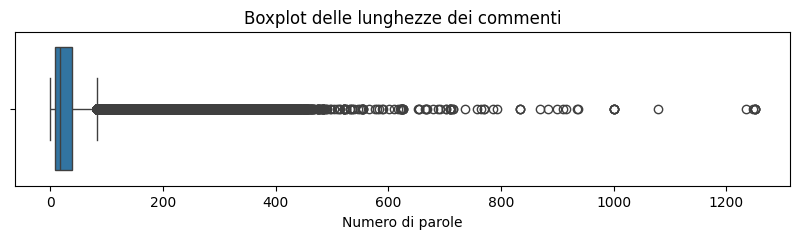

In [ ]:
# controllo l'eventuale presenza di outliers

dataset['comment_length'] = dataset['clean_comment_text'].apply(lambda x: len(x.split()))


plt.figure(figsize=(10, 2))
sns.boxplot(x=dataset['comment_length'])
plt.title('Boxplot delle lunghezze dei commenti')
plt.xlabel('Numero di parole')
plt.show()


In [ ]:
limite_95=dataset['comment_length'].quantile(0.95)

outliers = dataset[dataset['comment_length'] > limite_95]
print(f"Numero di outliers: {len(outliers)}")


Numero di outlier: 7876


Poichè rispetto alla totalità del dataset, gli outliers rappresentano una percentuale molto bassa, procedo con la loro rimozione.

In [ ]:
# Rimuovo gli outliers

dataset_filtered = dataset[dataset['comment_length'] <= limite_95]

dataset_filtered = dataset_filtered.dropna(subset=['clean_comment_text'])

# salvo i dati ripuliti e senza outliers
path = '/content/gdrive/MyDrive/Progetti Master/DeepLearning/dataset_filtrato.csv'

dataset_filtered.to_csv(path, index=False)



In [ ]:
# carico il nuovo dataset pulito e filtrato
dataset_new = pd.read_csv('/content/gdrive/MyDrive/Progetti Master/DeepLearning/dataset_filtrato.csv')

In [ ]:
dataset_new['clean_comment_text'].isna().sum()


np.int64(0)

## Tokenizzazione

In [ ]:
tokenizer = Tokenizer(num_words=20000, split=' ')
tokenizer.fit_on_texts(dataset_new["clean_comment_text"].values)
X = tokenizer.texts_to_sequences(dataset_new["clean_comment_text"].values)
X = pad_sequences(X)

In [ ]:
X_clean_df = pd.DataFrame(X)

## Verifica di un eventuale sbilanciamento del dataset
Il dataset risulta essere fortemente sbilanciato verso la classe ngativa (0), come visibile anche graficamente dagli istogrammi. Sarà quindi necessario applicare delle tecniche di bilanciamento per ridurlo.

In [ ]:
# controllo se il dataset è sbilanciato
dataset_new["toxic"].value_counts()
dataset_new["severe_toxic"].value_counts()
dataset_new["obscene"].value_counts()
dataset_new["threat"].value_counts()
dataset_new["insult"].value_counts()
dataset_new["identity_hate"].value_counts()

,count
identity_hate,
0,150299
1,1350


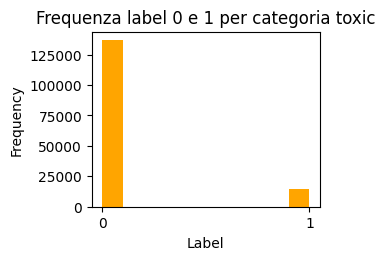

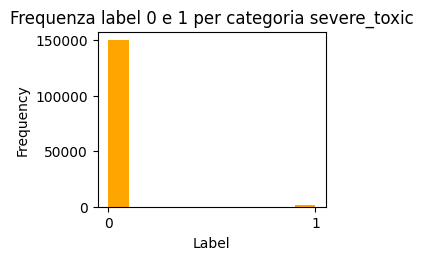

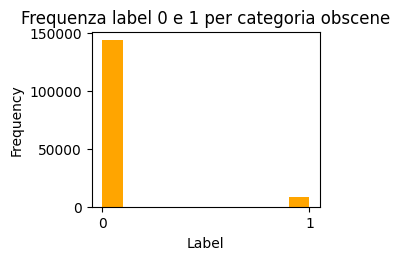

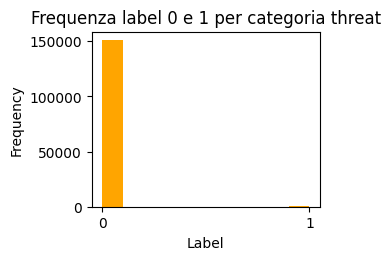

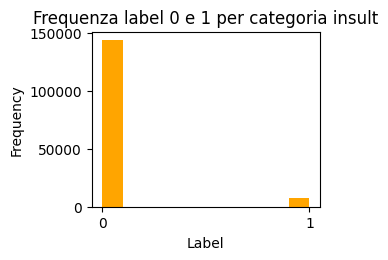

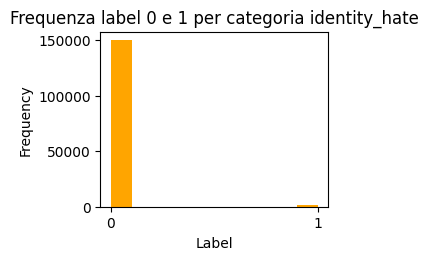

In [ ]:
col_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"] # non considero la colonna con le somme
pos = 1

for name in col_names:
  plt.figure(figsize=(10,5))
  plt.subplot(2, 3, pos)
  plt.hist(x = dataset_new[name], color='orange')
  plt.xlabel("Label")
  plt.xticks(ticks=np.array([0,1]), labels=[0,1] )
  plt.ylabel("Frequency")
  plt.title("Frequenza label 0 e 1 per categoria "+ name)
  pos=pos+1
plt.show()



In [ ]:
print(dataset_new[col_names].sum(axis=0))


toxic            14783
severe_toxic      1462
obscene           8154
threat             461
insult            7634
identity_hate     1350
dtype: int64


## Suddivisione del dataset in set di train e di test

Suddivido il dataset in set di train e di test cerco di suddividere i dati mantenendo la stessa proporzione delle classi anche nei dati di train e test tramite il parametro stratify, concentradomi su una delle classi più rappresentative del dataset (toxic) per migliorare la  generalizzazione e performance del modello.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_clean_df,
    dataset_new[col_names],
    test_size=0.2,
    stratify=dataset_new['toxic'],  #stratificazione su toxic
    random_state=42
)


In [ ]:
y_train

,toxic,severe_toxic,obscene,threat,insult,identity_hate
108841,0,0,0,0,0,0
116636,0,0,0,0,0,0
36081,0,0,0,0,0,0
21220,1,0,0,0,0,0
145207,0,0,0,0,0,0
...,...,...,...,...,...,...
21896,1,1,1,0,1,0
69024,0,0,0,0,0,0
138234,0,0,0,0,0,0
14137,0,0,0,0,0,0


In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,115
108841,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2332,66
116636,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2523,1452
36081,0,0,0,0,0,0,0,0,0,0,...,0,0,0,133,3435,438,29,6945,3806,550
21220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,52,2,2077,96,7185,317
145207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1457,318,1371,12,111,1098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21896,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2452,145,1546,2452,14533
69024,0,0,0,0,0,0,0,0,0,0,...,17384,497,341,3973,1247,8276,5108,111,212,1463
138234,0,0,0,0,0,0,0,0,0,0,...,8432,2217,1312,149,97,1073,45,5638,297,202
14137,0,0,0,0,0,0,0,0,0,0,...,8133,502,2339,779,5084,44,2,3121,9,274


## Applicazione di MLSMOTE per ridurre lo sbilanciamento del dataset
Poichè, come precedentemente anticipato, il dataset presenta un fortissimo sbilanciamento, non è possibile generare un numero di campioni tale da poter rendere le 2 classi perfettamente bilanciate senza incorrere nel rischio di overfitting, aggiunto ad un ingente costo computazionale. Il numero di campioni da generare è stato quindi calcolato effettuando una media dei campioni positivi totali e calcolando il gap per raggiungere il target per ogni label in considerazione. Al termine, i nuovi campioni generati sono stati accorpati al resto del dataset di train.



In [ ]:
positive_counts = y_train.sum(axis=0)
max_pos = positive_counts.max()
mean_pos = positive_counts.mean()

In [ ]:
target_per_class = int(mean_pos)

gap = np.maximum(target_per_class - positive_counts, 0)
total_new_samples = int(gap[gap > 0].sum())

print(f"Imposto target_per_class a {target_per_class}")
print("Genererò", total_new_samples, "nuovi campioni sintetici multilabel")

Imposto target_per_class a 4522
Genererò 10938 nuovi campioni sintetici multilabel


In [ ]:
X_sub, y_sub = get_minority_instace(X_train, y_train)
X_res,y_res =MLSMOTE(X_sub, y_sub, total_new_samples)


In [ ]:
y_res

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1.0,0.0,1.0,1.0,1.0,0.0
1,1.0,1.0,1.0,0.0,1.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0
3,1.0,1.0,1.0,0.0,1.0,1.0
4,1.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...
10933,1.0,0.0,0.0,0.0,1.0,0.0
10934,1.0,1.0,1.0,0.0,1.0,0.0
10935,1.0,1.0,1.0,0.0,1.0,1.0
10936,1.0,1.0,1.0,0.0,1.0,0.0


In [ ]:
#  indici usati per l'oversampling
minority_indices = get_index(y_train)


X_majority = X_train[~X_train.index.isin(minority_indices)]
y_majority = y_train[~y_train.index.isin(minority_indices)]


X_train_aug = pd.concat([X_majority, X_res], axis=0).reset_index(drop=True)
y_train_aug = pd.concat([y_majority, y_res], axis=0).reset_index(drop=True)


## Definizione del modello

Il modello implementato utilizza un layer di embedding per trasformare le parole in vettori densi, seguito da uno strato LSTM con regolarizzazione L2 per catturare le dipendenze sequenziali del testo. La rete è stabilizzata attraverso un layer di Batch Normalization e resa più robusta grazie a due strati di Dropout (50% e 40%), che riducono l’overfitting. L’output è composto da sei neuroni con attivazione sigmoid, che restituiscono la probabilità di appartenenza del commento a ciascuna delle sei categorie di tossicità.

In [ ]:


max_len=0
for element in X:
  length = len(element)
  if length > max_len:
    max_len=length

# print(max_len)


#VOCAB_SIZE = 136992  # parole uniche nel tokenizer
vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))

model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))

# output
model.add(Dense(6, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# 1. Fit del modello sul dataset composto dall'unione dei dati iniziali e dei dati generati da MLSMOTE

In [ ]:


model.fit(X_train_aug, y_train_aug,
          validation_split=0.2,
          epochs=15,
          batch_size=64,
          callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/15
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 711s 426ms/step - accuracy: 0.6408 - loss: 0.2022 - val_accuracy: 0.9934 - val_loss: 1.8867
Epoch 2/15
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 741s 426ms/step - accuracy: 0.9529 - loss: 0.0450 - val_accuracy: 0.9934 - val_loss: 1.9651
Epoch 3/15
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 751s 432ms/step - accuracy: 0.9877 - loss: 0.0369 - val_accuracy: 0.9934 - val_loss: 2.1656
Epoch 4/15
1654/1654 ━━━━━━━━━━━━━━━━━━━━ 745s 433ms/step - accuracy: 0.9914 - loss: 0.0341 - val_accuracy: 0.9934 - val_loss: 2.3608


## Valutazione della performance del modello
Impostando un valore unico di threshold per la predizione, il modello non riusciva ad intercettare nulla per le classi severe_toxic, threat, identity_hate, motivo per cui è stato creato un array contenente valori diversi per ognuno dei label. Nonostante tale accorgimento, la performance del modello non è migliorata nell'intercettazione delle classi appena citate, motivo per cui è stato effettuato un ulteriore tentativo di generazione dei dati con MLSMOTE, concentrandosi sulle 3 classi meno rappresentate.

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred_bin = (y_pred_prob >= 0.3).astype(int)

948/948 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step


In [ ]:
#  diverse soglie per ogni classe

thresholds = np.array([0.5, 0.3, 0.5, 0.3, 0.5, 0.3])
y_pred_bin = (y_pred_prob >= thresholds).astype(int)


In [ ]:

print(classification_report(y_test, y_pred_bin, target_names=col_names, zero_division=0))


               precision    recall  f1-score   support

        toxic       0.93      0.56      0.70      2957
 severe_toxic       0.00      0.00      0.00       279
      obscene       0.85      0.60      0.70      1606
       threat       0.00      0.00      0.00        95
       insult       0.77      0.51      0.61      1502
identity_hate       0.00      0.00      0.00       271

    micro avg       0.86      0.51      0.64      6710
    macro avg       0.42      0.28      0.34      6710
 weighted avg       0.78      0.51      0.62      6710
  samples avg       0.05      0.04      0.04      6710



Dal classification report emerge un comportamento fortemente sbilanciato del modello, con buone performance sulle classi più rappresentate e risultati nulli su quelle minoritarie. Le categorie toxic, obscene e insult mostrano valori soddisfacenti in termini di precisione, recall e F1-score:

- toxic raggiunge un F1-score di 0.76, con una precisione elevata (0.81) e un recall più contenuto (0.73), suggerendo che il modello tende a individuare solo i casi più evidenti;

- obscene presenta un buon equilibrio tra precisione e recall, con un F1-score di 0.75, che indica una capacità complessiva efficace nel riconoscere questa categoria;

- insult mostra una buona precisione (0.63), ma un recall relativamente più basso (0.77), il che segnala una tendenza a non riconoscere una parte rilevante dei casi positivi.

- Al contrario, le classi severe_toxic, threat e identity_hate registrano valori nulli per tutti gli indicatori (precisione, recall, F1-score), segno che il modello non riesce a individuare alcun esempio positivo appartenente a queste categorie. Questo risultato è molto probabilmente attribuibile alla forte scarsità di esempi per queste classi nel dataset di addestramento.

Per ovviare a questo limite, è stato effettuato un secondo tentativo di bilanciamento dei dati, con la generazione di nuovi esempi sintetici esclusivamente per le classi severe_toxic, threat e identity_hate, al fine di migliorare la capacità del modello di generalizzare anche su queste categorie meno rappresentate.

## Generazione di nuovi dati con MLSMOTE per le sole classi severe_toxic, threat, identity_hate

In [ ]:


#  Definisco le classi su cui applicare MLSMOTE
target_labels = ['severe_toxic', 'threat', 'identity_hate']

positive_counts = y_train[target_labels].sum()
print("Positive counts prima del bilanciamento:\n", positive_counts)

# target minimo per ciascuna classe
mean_pos = positive_counts.mean()
min_target_per_class = int(mean_pos)
#min_target_per_class = 1000
gap_model2 = np.maximum(min_target_per_class - positive_counts, 0)
print("Campioni da generare per ciascuna classe:\n", gap_model2)

# seleziono campioni che hanno almeno una label tra quelle target
minority_indices = y_train[target_labels].any(axis=1)
X_minority = X_train[minority_indices].reset_index(drop=True)
y_minority = y_train[minority_indices].reset_index(drop=True)


n_samples = int(gap_model2.sum())
print(f"Genererò {n_samples} nuovi campioni sintetici multilabel")

# MLSMOTE
X_synth, y_synth = MLSMOTE(X_minority, y_minority, n_samples)

# Concatenazione con il training set originale
X_train_aug_model2 = pd.concat([X_train, X_synth], axis=0).reset_index(drop=True)
y_train_aug_model2 = pd.concat([y_train, y_synth], axis=0).reset_index(drop=True)



Positive counts prima del bilanciamento:
 severe_toxic     1183
threat            366
identity_hate    1079
dtype: int64
Campioni da generare per ciascuna classe:
 severe_toxic       0
threat           510
identity_hate      0
dtype: int64
Genererò 510 nuovi campioni sintetici multilabel


## 2. Fit del modello sul dataset composto dall'unione dei dati iniziali e dei dati generati da MLSMOTE per le classi severe_toxic, threat, identity_hate


In [ ]:


model.fit(X_train_aug_model2, y_train_aug_model2,
          validation_split=0.2,
          epochs=15,
          batch_size=64,
          callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/15
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 693s 446ms/step - accuracy: 0.9806 - loss: 0.0670 - val_accuracy: 0.9907 - val_loss: 0.2219
Epoch 2/15
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 742s 446ms/step - accuracy: 0.9936 - loss: 0.0525 - val_accuracy: 0.9907 - val_loss: 0.1728
Epoch 3/15
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 741s 446ms/step - accuracy: 0.9927 - loss: 0.0491 - val_accuracy: 0.9907 - val_loss: 0.1833
Epoch 4/15
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 740s 444ms/step - accuracy: 0.9877 - loss: 0.0456 - val_accuracy: 0.9907 - val_loss: 0.1807
Epoch 5/15
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 693s 446ms/step - accuracy: 0.9724 - loss: 0.0426 - val_accuracy: 0.9904 - val_loss: 0.1918


In [ ]:
y_pred_prob_model2 = model.predict(X_test)

thresholds_model2 = np.array([0.5, 0.1, 0.5, 0.1, 0.5, 0.1])
y_pred_bin_model2 = (y_pred_prob_model2 >= thresholds_model2).astype(int)


print(classification_report(y_test, y_pred_bin_model2, target_names=col_names, zero_division=0))


948/948 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step
               precision    recall  f1-score   support

        toxic       0.76      0.78      0.77      2957
 severe_toxic       0.18      0.92      0.30       279
      obscene       0.67      0.87      0.76      1606
       threat       0.00      0.00      0.00        95
       insult       0.62      0.81      0.70      1502
identity_hate       0.12      0.75      0.21       271

    micro avg       0.53      0.80      0.64      6710
    macro avg       0.39      0.69      0.46      6710
 weighted avg       0.65      0.80      0.70      6710
  samples avg       0.05      0.07      0.06      6710



Dopo l’applicazione del bilanciamento tramite MLSMOTE, mirato esclusivamente alle tre classi meno rappresentate (severe_toxic, threat e identity_hate), e l’introduzione di soglie decisionali differenziate (0.1 per le classi minoritarie, 0.5 per le restanti), il modello ha mostrato un miglioramento significativo nella capacità di riconoscere i casi rari, pur con qualche compromesso in termini di precisione.

La classe severe_toxic, che in precedenza aveva un recall pari a zero, mostra ora un recall di 0.92 e un F1-score di 0.30: ciò indica che il modello riesce finalmente a intercettare la maggior parte dei casi positivi, sebbene con una precisione ancora bassa (0.18), dovuta all’aumento dei falsi positivi. Analogamente, anche la classe identity_hate registra progressi significativi (recall 0.75, F1-score 0.21), confermando l’efficacia dell’approccio nel trattare le categorie meno frequenti. La classe threat, invece, rimane problematica, con valori ancora nulli per precisione, recall e F1-score: ciò suggerisce che, nonostante il bilanciamento, il modello fatica a generalizzare su questa categoria, probabilmente per via dell’esiguità del supporto e della natura più ambigua dei dati.

Le classi più rappresentate mantengono invece prestazioni stabili.

Questo dimostra che l’introduzione di dati sintetici e la modifica delle soglie decisionali non ha compromesso l’accuratezza del modello sulle classi principali, anzi ha reso il modello nel complesso più bilanciato.

In conclusione, l’approccio adottato ha portato a un miglioramento significativo nel recall delle classi meno rappresentate, aumentando la sensibilità del modello verso segnali rari. Resta tuttavia margine di miglioramento, soprattutto per quanto riguarda la precisione delle classi minoritarie e la capacità di discriminazione della classe threat.

